In [39]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
# tai from ... import *

In [40]:
df = database_query("SELECT * FROM SensorData limit 10000")
df.head()

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


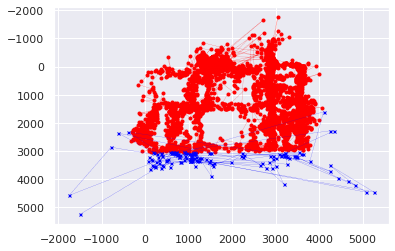

In [43]:
df = find_outliers(df)

In [44]:
df = clean_dataframe(df)
df1.head(5)

,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8


In [46]:
grid_size = 50
df = xy_to_grid(df1, df1.x, df1.y, grid_size)
df

,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,2,8,35,15,785
1,1,2020-06-24 15:20:08.620,2870,-344,2,8,36,14,736
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,36,14,736
3,1,2020-06-24 15:20:09.623,2894,-254,2,8,36,15,786
4,1,2020-06-24 15:20:10.116,2888,-188,2,8,36,16,836
...,...,...,...,...,...,...,...,...,...
9623,1,2020-06-29 13:19:16.418,1301,-120,0,6,18,17,868
9624,1,2020-06-29 13:19:25.418,1301,-119,0,6,18,17,868
9625,1,2020-06-29 13:19:35.418,1305,-112,0,6,18,17,868
9626,1,2020-06-29 13:19:45.418,1305,-112,0,6,18,17,868


In [47]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [48]:
X = df[['x_grid', 'y_grid']]

In [49]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")


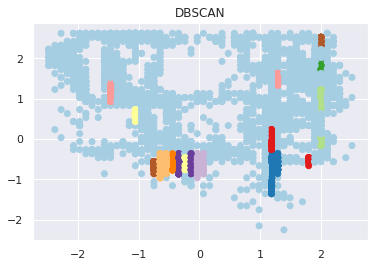

In [50]:
dbscan(X, 0.10, 35)

In [51]:
#df.timestamp = pd.to_datetime(df.timestamp)
df.timestamp


0      2020-06-24 15:20:08.533
1      2020-06-24 15:20:08.620
2      2020-06-24 15:20:09.623
3      2020-06-24 15:20:09.623
4      2020-06-24 15:20:10.116
                 ...          
9623   2020-06-29 13:19:16.418
9624   2020-06-29 13:19:25.418
9625   2020-06-29 13:19:35.418
9626   2020-06-29 13:19:45.418
9627   2020-06-29 13:19:54.418
Name: timestamp, Length: 9628, dtype: datetime64[ns]

In [53]:
import numpy as np

df['distancex'] = df['x'].diff()
df['distancey'] = df['y'].diff()
df['distance'] = (df['distancex']**2 + df['distancey']**2)
df['distance'] = (np.sqrt(df['distance'])/100)

df = df.drop('distancex', 1)
df = df.drop('distancey', 1)


#df['distance'] = ((np.sqrt((df['x'] - df['x'].shift(-1))**2 + (df['y'] - df['y'].shift(-1))**2))/161.15)
#df['distance'] = ((np.sqrt((df['x'].diff()**2 + (df['y'].diff()**2))/161.15)))


df['ero'] = df.timestamp.diff()
df['ero'] = df.ero.dt.seconds                   
                   
df['speedkm'] = df['distance']/df['ero']*3.6


    # Poistetaan liian nopeat, yli 7km/h
df = df.drop(df[(df.speedkm > 7)].index)
    
df = df.dropna()
df

,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id,distance,ero,speedkm
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,36,14,736,0.460000,1.0,1.656000
7,1,2020-06-24 15:20:12.995,2928,5,2,8,37,18,937,1.160689,1.0,4.178482
10,1,2020-06-24 15:20:15.659,3173,-101,2,8,39,17,889,1.639329,1.0,5.901585
12,1,2020-06-24 15:20:17.590,3349,-92,2,8,41,17,891,1.627882,1.0,5.860375
13,1,2020-06-24 15:20:21.982,3642,252,2,8,45,21,1095,4.518683,4.0,4.066815
...,...,...,...,...,...,...,...,...,...,...,...,...
9623,1,2020-06-29 13:19:16.418,1301,-120,0,6,18,17,868,0.028284,10.0,0.010182
9624,1,2020-06-29 13:19:25.418,1301,-119,0,6,18,17,868,0.010000,9.0,0.004000
9625,1,2020-06-29 13:19:35.418,1305,-112,0,6,18,17,868,0.080623,10.0,0.029024
9626,1,2020-06-29 13:19:45.418,1305,-112,0,6,18,17,868,0.000000,10.0,0.000000


In [61]:
df.speedkm.sample(20)

4938    0.070729
5592    0.077880
308     0.032599
3029    3.472233
9502    0.056851
336     2.089241
2548    0.012980
5415    0.061622
4264    0.039763
788     0.126000
5102    0.076837
4405    0.030547
2258    0.276301
3542    0.911447
4710    0.093963
2111    0.207305
8428    0.021898
7073    3.686486
1355    0.045607
3927    0.235573
Name: speedkm, dtype: float64